In [1]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
%matplotlib inline 
import os,time,math

In [155]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_selection import RFE
from sklearn.feature_selection import RFECV
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import LassoCV

## Load Data

In [5]:
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/pima-indians-diabetes/pima-indians-diabetes.data"
names = ['preg', 'plas', 'pres', 'skin', 'test', 'mass', 'pedi', 'age', 'class']
dataframe = pd.read_csv(url, names=names)
array = dataframe.values
X = array[:,0:8]
Y = array[:,8]

## Feature Extraction

### SelectKBest 
#### Selecting top k features from dataset based on function such as Chi2

In [115]:
test = SelectKBest(k=4,score_func=chi2)

In [116]:
fit = test.fit(X,Y)

In [117]:
fit.transform(X)

array([[ 148. ,    0. ,   33.6,   50. ],
       [  85. ,    0. ,   26.6,   31. ],
       [ 183. ,    0. ,   23.3,   32. ],
       ..., 
       [ 121. ,  112. ,   26.2,   30. ],
       [ 126. ,    0. ,   30.1,   47. ],
       [  93. ,    0. ,   30.4,   23. ]])

In [118]:
test = SelectKBest(score_func=chi2, k=4)
fit = test.fit(X, Y)
# summarize scores
np.set_printoptions(precision=3)
#print score function on each of the parameter
print(fit.scores_)
#extracting selected features basis fit
features = fit.transform(X)
# summarize selected features
print(features[0:5,:])

[  111.52   1411.887    17.605    53.108  2175.565   127.669     5.393
   181.304]
[[ 148.     0.    33.6   50. ]
 [  85.     0.    26.6   31. ]
 [ 183.     0.    23.3   32. ]
 [  89.    94.    28.1   21. ]
 [ 137.   168.    43.1   33. ]]


In [119]:
fit.get_support()

array([False,  True, False, False,  True,  True, False,  True], dtype=bool)

In [120]:
mask = fit.get_support() #list of booleans
new_features = [] # The list of your K best features

for bool, feature in zip(mask, names):
    if bool:
        new_features.append(feature)

In [121]:
pd.DataFrame({'Names':np.array(names[:-1]), 'Scores': fit.scores_}).sort_values('Scores',ascending = False)

,Names,Scores
4,test,2175.565273
1,plas,1411.887041
7,age,181.303689
5,mass,127.669343
0,preg,111.519691
3,skin,53.108040
2,pres,17.605373
6,pedi,5.392682


### Recursive Feature Elimination
####  Recursively removing attributes and building model on those attributes

In [122]:
model = LogisticRegression()

In [123]:
rfe_model = RFECV(estimator=model, step=1, cv=StratifiedKFold(2),
              scoring='accuracy')

In [124]:
fit = rfe_model.fit(X,Y)

In [125]:
mask = fit.get_support() #list of booleans
new_features = [] # The list of your K best features

for bool, feature in zip(mask, names):
    if bool:
        new_features.append(feature)

In [126]:
new_features

['preg', 'plas', 'mass', 'pedi']

In [133]:
pd.DataFrame({'Names':np.array(names[:-1]), 'Ranking': fit.ranking_}).sort_values('Ranking',ascending = True)

,Names,Ranking
0,preg,1
1,plas,1
5,mass,1
6,pedi,1
2,pres,2
7,age,3
3,skin,4
4,test,5


Optimal number of features : 4


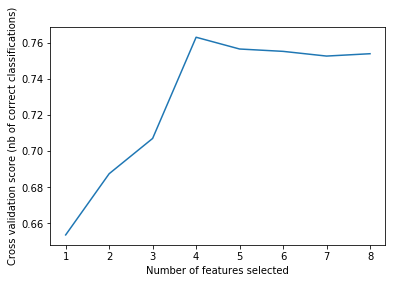

In [136]:
print("Optimal number of features : %d" % rfe_model.n_features_)

# Plot number of features VS. cross-validation scores
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (nb of correct classifications)")
plt.plot(range(1, len(rfe_model.grid_scores_) + 1), rfe_model.grid_scores_)
plt.show()

### SelectFromModel
#### Feature Importance using models

In [156]:
clf = LassoCV()

In [223]:
sfm = SelectFromModel(clf,threshold=0.00001)
# sfm = SelectFromModel(clf)

In [224]:
sfm.fit(X,Y)

SelectFromModel(estimator=LassoCV(alphas=None, copy_X=True, cv=None, eps=0.001, fit_intercept=True,
    max_iter=1000, n_alphas=100, n_jobs=1, normalize=False, positive=False,
    precompute='auto', random_state=None, selection='cyclic', tol=0.0001,
    verbose=False),
        norm_order=1, prefit=False, threshold=1e-05)

In [225]:
n_features = sfm.transform(X).shape[1]

# Reset the threshold till the number of features equals two.
# Note that the attribute can be set directly instead of repeatedly
# fitting the metatransformer.
while n_features >4:
    sfm.threshold += 0.00005
    X_transform = sfm.transform(X)
    n_features = X_transform.shape[1]

In [226]:
mask = sfm.get_support() #list of booleans
new_features = [] # The list of your K best features

for bool, feature in zip(mask, names):
    if bool:
        new_features.append(feature)

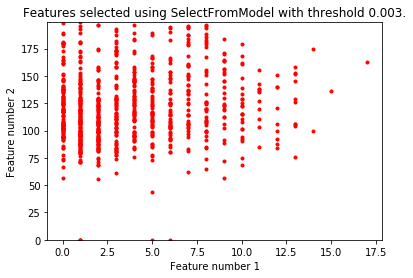

In [227]:
# Plot the selected two features from X.
plt.title(
    "Features selected using SelectFromModel with "
    "threshold %0.3f." % sfm.threshold)
feature1 = X_transform[:, 0]
feature2 = X_transform[:, 1]
plt.plot(feature1, feature2, 'r.')
plt.xlabel("Feature number 1")
plt.ylabel("Feature number 2")
plt.ylim([np.min(feature2), np.max(feature2)])
plt.show()

In [228]:
new_features

['preg', 'plas', 'mass', 'pedi']

### Tree Based Feature Selection


In [263]:
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import RandomForestClassifier

In [264]:
clf = ExtraTreesClassifier()
clf2 = RandomForestClassifier()

In [265]:
clf.fit(X,Y)
clf2.fit(X,Y)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [256]:
names

['preg', 'plas', 'pres', 'skin', 'test', 'mass', 'pedi', 'age', 'class']

In [266]:
print(clf.feature_importances_) # sum of 1 - in % terms
print(clf2.feature_importances_)

[ 0.114  0.224  0.103  0.071  0.082  0.155  0.12   0.131]
[ 0.08   0.24   0.1    0.075  0.073  0.163  0.12   0.149]


In [267]:
feature_impdata = pd.DataFrame({'Names':np.array(names[:-1]), 'Ranking': clf.feature_importances_}).sort_values('Ranking',ascending = False)
feature_impdata_rf = pd.DataFrame({'Names':np.array(names[:-1]), 'Ranking': clf2.feature_importances_}).sort_values('Ranking',ascending = False)

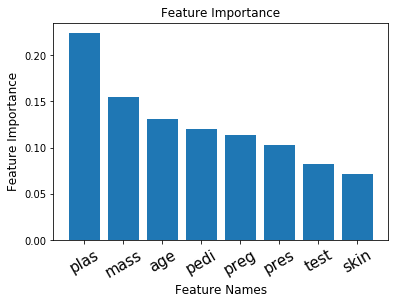

In [268]:
index = np.arange(len(feature_impdata.Names))
plt.bar(index, feature_impdata.Ranking)
plt.xlabel('Feature Names', fontsize=12)
plt.ylabel('Feature Importance', fontsize=12)
plt.xticks(index, feature_impdata.Names, fontsize=15, rotation=30)
plt.title('Feature Importance')
plt.show()

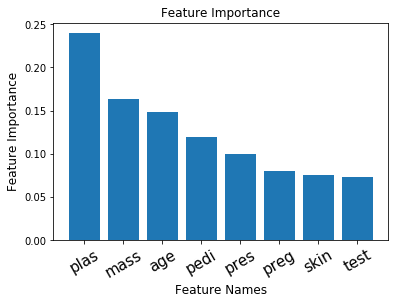

In [269]:
index = np.arange(len(feature_impdata_rf.Names))
plt.bar(index, feature_impdata_rf.Ranking)
plt.xlabel('Feature Names', fontsize=12)
plt.ylabel('Feature Importance', fontsize=12)
plt.xticks(index, feature_impdata_rf.Names, fontsize=15, rotation=30)
plt.title('Feature Importance')
plt.show()